**Haniyeh Ehsani Oskouie**

**306300374**

# CS247 Advanced Data Mining - Assignment 2
## Deadline: 11:59PM, January 31, 2023

## Instructions
Each assignment is structured as a Jupyter notebook, offering interactive tutorials that align with our lectures. You will encounter two types of problems: *write-up problems* and *coding problems*.

1. **Write-up Problems:** These problems are primarily theoretical, requiring you to demonstrate your understanding of lecture concepts and to provide mathematical proofs for key theorems. Your answers should include sufficient steps for the mathematical derivations.
2. **Coding Problems:** Here, you will be engaging with practical coding tasks. These may involve completing code segments provided in the notebooks or developing models from scratch.

To ensure clarity and consistency in your submissions, please adhere to the following guidelines:

* For write-up problems, use Markdown bullet points to format text answers. Also, express all mathematical equations using $\LaTeX$ and avoid plain text such as `x0`, `x^1`, or `R x Q` for equations.
* For coding problems, comment on your code thoroughly for readability and ensure your code is executable. Non-runnable code may lead to a loss of **all** points. Coding problems have automated grading, and altering the grading code will result in a deduction of **all** points.
* Your submission should show the entire process of data loading, preprocessing, model implementation, training, and result analysis. This can be achieved through a mix of explanatory text cells, inline comments, intermediate result displays, and experimental visualizations.

### Submission Requirements

* Submit your solutions through GradeScope in BruinLearn.
* Late submissions are allowed up to 24 hours post-deadline with a penalty factor of $\mathbf{1}(t\leq24)e^{-(\ln(2)/12)t}$.

### Collaboration and Integrity

* Collaboration is encouraged, but all final submissions must be your own work. Please acknowledge any collaboration or external sources used, including websites, papers, and GitHub repositories.
* Any suspicious cases of academic misconduct will be reported to The Office of the Dean of Students.

## Outline
* Part 1: Neural Networks and Deep Learning (70 points + 20 bonus points)
* Part 2: Topic Model: Probablistic Latent Semantic Indexing (50 points)

## Part 1: Neural Networks and Deep Learning (70 points + 20 bonus points)

PyTorch is a system for executing dynamic computational graphs over `Tensor` objects that behave similarly as numpy `ndarray`. It comes with a powerful automatic differentiation engine that removes the need for manual back-propagation.

The objective of this exercise is to gain hands-on experience in deep learning using PyTorch, focusing on understanding and implementing different levels of abstraction and advanced training techniques in neural network development.

### Section 1.1: PyTorch Fundamentals (55 points)

In the first part, we will learn to build neural networks with PyTorch. We will start with a fully-connected neural network using basic tensor operations in PyTorch and then move to a three-layer convolutional neural network using PyTorch modules. We will train our neural networks on the CIFAR-10 dataset and compare their performance.

In [ ]:
import torch
import torchvision
import numpy as np
from torchvision import transforms as T
from torch.utils.data import sampler, DataLoader

import os
from os import path

data_path = path.join(os.getcwd(), 'data')

batch_size = 64
num_train_samples = 48000

# Transformations and CIFAR-10 dataset loading
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_set = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
train_loader = DataLoader(
    train_set, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(num_train_samples)))
valid_loader = DataLoader(
    train_set, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(num_train_samples, 50000)))

test_set = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:01<00:00, 87824349.17it/s]


Extracting /content/data/cifar-10-python.tar.gz to /content/data
Files already downloaded and verified


#### GPU Support

Considering the size of the training data, it is suggested to use [Google Colab](https://colab.research.google.com/) or a GPU server for this exercise. If you are using Colab, you can manually switch to a CPU device on Colab by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`.

In [ ]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
elif USE_GPU and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

#### Exercise 1: Linear Layers and ReLU Layers (12 points)
For this exercise, we will build a two-layer fully-connected network with low-level PyTorch tensor operations.
To be specific, we are going to implement a custom `Linear` layer and a ReLU activation layer, and understand the `forward` and `backward` passes through these layers.
In PyTorch, `torch.autograd.Function` allows for the customization of both the forward and backward passes of an operation. For educational purposes, understanding and implementing these functions is crucial to grasp the underlying mechanics of neural networks and automatic differentiation.

Caveat: The primary goal is to understand the principles rather than creating optimized code. In practical applications, one would typically use PyTorch's built-in layers and functions which are highly optimized. Thus, in typical scenarios, one only needs to define the forward pass. However, if you need a layer with a specific functionality not available in PyTorch, you will need to implement both the forward and backward passes.

Firstly, let's start with (1) a custom linear layer and (2) a ReLU activation layer that uses `torch.autograd.Function` to define the `forward` and `backward` passes.
The `forward` passes for these layers have been provided. Your task is to complete the implementation by coding the `backward` passes.

**Implement the Backward Pass for the Linear Layer**:
   - Recall that the linear layer performs a transformation $\boldsymbol{y} = \boldsymbol{xW}^\top + \boldsymbol{b}$.
   - Your goal is to compute the gradients with respect to the input $\boldsymbol{x}$, weights $\boldsymbol{W}$, and bias $\boldsymbol{b}$: $\frac{\partial L}{\partial \boldsymbol{x}}$, $\frac{\partial L}{\partial \boldsymbol{W}}$, and $\frac{\partial L}{\partial \boldsymbol{b}}$.

In [ ]:
from torch import nn
from torch.autograd import Function

# Custom Linear Layer
class CustomLinearFunction(Function):
    @staticmethod
    def forward(ctx, input, weight, bias=None):
        """
        The forward pass of the custom linear layer.

        Parameters:
        - ctx: Context object that can be used to stash information for backward computation.
        - input: Input tensor of shape (batch_size, input_features).
        - weight: Weight tensor of shape (output_features, input_features).
        - bias: Optional bias tensor of shape (output_features).

        Returns:
        - Tensor: The output of the linear transformation.
        """
        ctx.save_for_backward(input, weight, bias)          # Stash input, weight, and bias for the backward pass
        output = input.mm(weight.t())                       # Matrix multiplication
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)   # Bias addition
        return output

    @staticmethod
    def backward(ctx, grad_output):
        """
        The backward pass of the custom linear layer.

        Parameters:
        - ctx: Context object containing saved tensors.
        - grad_output: Gradient of the loss w.r.t. the output of this layer.

        Returns:
        - Tuple containing gradients w.r.t input, weight, and bias.
        """
        input, weight, bias = ctx.saved_tensors
        # TODO: Implement the backward pass for the linear layer

        grad_input = torch.matmul(grad_output, weight)
        grad_weight = torch.matmul(grad_output.t(), input)
        grad_bias = grad_output

        return grad_input, grad_weight, grad_bias

In [ ]:
# Wrapper class for the custom linear layer
class CustomLinear(nn.Module):
    def __init__(self, input_features, output_features):
        """
        Custom linear layer module.

        Parameters:
        - input_features: Number of input features.
        - output_features: Number of output features.
        """
        super(CustomLinear, self).__init__()
        self.weight = nn.Parameter(torch.randn(output_features, input_features))
        self.bias = nn.Parameter(torch.randn(output_features))

    def forward(self, input):
        """
        Forward pass of the custom linear module.

        Parameters:
        - input: Input tensor of shape (batch_size, input_features).

        Returns:
        - Tensor: The output of the layer.
        """
        return CustomLinearFunction.apply(input, self.weight, self.bias)

The following code verifies that the custom linear layer produce outputs and gradients that are close to PyTorch's own implementations.

In [ ]:
import torch
import torch.nn.functional as F

input_features = 10
output_features = 5
batch_size = 3

# Create a test input
test_input_custom = torch.randn(batch_size, input_features, requires_grad=True)
test_input_torch = test_input_custom.clone().detach().requires_grad_(True)

# Custom linear layer
custom_linear = CustomLinear(input_features, output_features)
custom_output = custom_linear(test_input_custom)

# PyTorch linear layer
torch_linear = torch.nn.Linear(input_features, output_features)
# Copy weights and biases from custom_linear
torch_linear.weight.data = custom_linear.weight.data
torch_linear.bias.data = custom_linear.bias.data
torch_output = torch_linear(test_input_torch)

# Backward pass to test gradients
custom_output.retain_grad()
torch_output.retain_grad()
custom_output.sum().backward()
torch_output.sum().backward()

# Compare gradients
assert torch.allclose(custom_linear.weight.grad, torch_linear.weight.grad, atol=1e-6)
assert torch.allclose(custom_linear.bias.grad, torch_linear.bias.grad, atol=1e-6)
assert torch.allclose(test_input_custom.grad, test_input_torch.grad, atol=1e-6)

**Implement the Backward Pass for the ReLU Layer**:
   - The ReLU function is $f(\boldsymbol{x}) = \max(0, \boldsymbol{x})$.
   - For the backward pass, calculate $\frac{\partial L}{\partial \boldsymbol{x}}$ for the ReLU layer.

In [ ]:
# Custom ReLU Activation
class CustomReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        """
        The forward pass of the custom ReLU layer.

        Parameters:
        - ctx: Context object for backward computation.
        - input: Input tensor.

        Returns:
        - Tensor: Output after applying ReLU.
        """
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        """
        The backward pass of the custom ReLU layer.

        Parameters:
        - ctx: Context object containing saved tensors.
        - grad_output: Gradient of the loss w.r.t. the output of this layer.

        Returns:
        - Tensor: Gradient w.r.t. the input.
        """
        input, = ctx.saved_tensors

        # TODO: Implement the backward pass for the ReLU layer
        grad_input = torch.where(input > 0, grad_output, 0)

        return grad_input

# Wrapper class for the custom ReLU layer
class CustomReLU(nn.Module):
    def forward(self, input):
        """
        Forward pass of the custom ReLU module.

        Parameters:
        - input: Input tensor.

        Returns:
        - Tensor: Output after applying ReLU.
        """
        return CustomReLUFunction.apply(input)

The following code checks whether the custom ReLU layer and PyTorch's built-in ReLU layer produce the same outputs and gradients for a given input.

In [ ]:
batch_size = 3
num_features = 10

# Create a test input
test_input_custom = torch.randn(batch_size, num_features, requires_grad=True)
test_input_torch = test_input_custom.clone().detach().requires_grad_(True)

# Custom ReLU layer
custom_relu = CustomReLU()
custom_output = custom_relu(test_input_custom)

# PyTorch ReLU function
torch_output = F.relu(test_input_torch)

# Backward pass to test gradients
custom_output.retain_grad()
torch_output.retain_grad()
custom_output.sum().backward()
torch_output.sum().backward()

# Compare gradients
assert torch.allclose(test_input_custom.grad, test_input_torch.grad, atol=1e-6)

#### Exercise 2: Two-Layer Fully-Connected Networks (4 points)
After we implemented the custom linear and ReLU layers, we can proceed to construct a two-layer fully-connected neural network.
Implement the `TwoLayerNet` class using these custom layers. The network architecture consists of two custom linear layers separated by a custom ReLU.
Ensure the network accepts CIFAR-10 images and outputs the correct class scores.

In [ ]:
hidden_dim = 128
num_classes = 10
shape = (32, 32, 3)
import torch.nn.functional as F

class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_dim, num_classes):
        """
        Two-layer fully connected network.

        Parameters:
        - input_size: Size of each input sample.
        - hidden_size: Size of hidden layer.
        - num_classes: Number of output classes.
        """
        super(TwoLayerNet, self).__init__()

        # TODO: Define layers here
        self.fc1 = CustomLinear(input_size, hidden_dim)
        self.fc2 = CustomLinear(hidden_dim, num_classes)
        self.relu = CustomReLU()

    def forward(self, x):
        """
        Forward pass of the network.

        Parameters:
        - x: Input tensor of shape (batch_size, input_size).

        Returns:
        - Tensor: Output of the network.
        """
        # TODO: Implement the forward pass for the two-layer network
        x = x.reshape((x.shape[0], np.prod(x.shape[1:])))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = TwoLayerNet(input_size=np.prod(shape), hidden_dim=hidden_dim, num_classes=num_classes)

# Verify that the output shape matches the expected shape
dummy_input = torch.randn(batch_size, *shape)
output = model(dummy_input)
expected_output_shape = (batch_size, num_classes)
assert output.shape == expected_output_shape

#### Exercise 3: Model Evaluation (5 points)
When training the model we will use the following function to evaluate our model on the training or validation sets.
In our exercise, the model performance is measured in terms of classification accuracy.
Please implement the `evaluate` function below. The function should return the classification accuracy of the model on the given dataset.

In [ ]:
def evaluate(model, test_loader):
    # TODO: Implement the evaluate function
    model.eval()
    accuracy = 0
    num_samples = 0
    for batch, labels in test_loader:
      batch, labels = batch.to(device), labels.to(device)
      accuracy += torch.sum(torch.argmax(model(batch), dim=1) == labels)
      num_samples += batch.shape[0]
    accuracy = accuracy.detach() / num_samples * 100

    return accuracy

#### Exercise 4: Model Training (10 points)
We can now set up a basic training loop to train our network. The training loop takes as input the neural network function, the training/validation data loader, the loss function, the optimizer, and the number of epochs to train for. The training loop should print the training loss and the accuracy of the validation set for every `print_every` epoch.

In [ ]:
print_every = 10

def train(model, train_loader, valid_loader, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        # TODO: Implement the training loop
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(train_loader):
          inputs, labels = batch[0].to(device), batch[1].to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

        if (epoch + 1) % print_every == 0:
            avg_loss = running_loss / len(train_loader)
            val_accuracy = evaluate(model, valid_loader)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

#### Exercise 5: Loss Functions and Optimizers (4 points)

Composing everything together, we can now train our two-layer fully-connected network on the CIFAR-10 dataset. We will use [the cross-entropy loss](https://pytorch.org/docs/stable/nn.html#loss-functions) and the [SGD optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) with a learning rate of 1e-3 to optimize the loss function. Please refer to the PyTorch documentation for more details on the loss function and optimizer.
Please run the training loop for 20 epochs and report the final accuracy of the model on the test set. You do not need to tune any hyperparameters at this point.

In [ ]:
model = TwoLayerNet(input_size=np.prod(shape), hidden_dim=hidden_dim, num_classes=num_classes).to(device)

# TODO: Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Run the training loop
train(model, train_loader, valid_loader, criterion, optimizer, epochs=20)

# TODO: Evaluate the model on the test set
test_accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Epoch [10/20], Loss: 8.0079, Validation Accuracy: 26.90%
Epoch [20/20], Loss: 6.8232, Validation Accuracy: 26.10%
Test Accuracy: 26.09%


#### Exercise 6: Three-Layer Convolutional Neural Networks (6 points)
Now let's implement a Convolutional Neural Network for CIFAR-10 classification. Your task is to build a 3-layer ConvNet followed by a two-layer fully-connected network. This network should provide a good balance between depth and complexity.

Your network should consist of three convolutional layers. Each [convolutional layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) is followed by a ReLU activation function and a [max-pooling layer](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html).
- The first convolutional layer should have 32 filters.
- The second layer should increase this to 64 filters.
- The third layer should have 128 filters.
- All of the convlutional layers should use a kernel size of 3x3 and a stride of 1x1.
- Each max-pooling layer should have a kernel size of 2 and a stride of 2.

After the convolutional layers, the network should have a fully connected layer leading to the final classification layer.
The output layer should have 10 units, corresponding to the 10 classes of CIFAR-10.

You should initialize the weight matrices of the convolutional layers using the [Kaiming normal initialization](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_).

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # TODO: Implement convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        # TODO: Implement the fully connected layer
        shape = (128, 2, 2)
#        hidden_dim = 128
#        num_classes = 10
#        self.fc = TwoLayerNet(input_size=np.prod(shape), hidden_dim=hidden_dim, num_classes=num_classes)

        self.fc = nn.Sequential(
            nn.Linear(np.prod(shape), 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

        # Initialize weights using Kaiming Normal initialization
        self._initialize_weights()

    def forward(self, x):
        # TODO: Implement the forward pass
        x = self.conv_layers(x)
        x = self.fc(x.reshape((x.shape[0], np.prod(x.shape[1:]))))
        return x

    def _initialize_weights(self):
        # TODO: Implement weight initialization using Kaiming Normal initialization
        for conv in self.conv_layers:
          if type(conv) == nn.Conv2d:
            nn.init.kaiming_uniform_(conv.weight)

Now train the three-layer `ConvNet` defined above on CIFAR-10. This should look very similar to training the two-layer network. Again, you don't need to tune any hyperparameters, but you should achieve above 50% accuracy on the test set after training for 20 epochs.

In [ ]:
model = ConvNet().to(device)

# TODO: Copy the definition of the loss function and the optimizer from earlier cells
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Run the training loop again
train(model, train_loader, valid_loader, criterion, optimizer, epochs=20)

# TODO: Evaluate the model on the test set
test_accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Epoch [10/20], Loss: 1.4414, Validation Accuracy: 48.30%
Epoch [20/20], Loss: 1.2336, Validation Accuracy: 56.30%
Test Accuracy: 55.20%


#### Exercise 7: Parameter Sizes (6 points)

Consider a tensor input with shape `[1, 3, 32, 32]` (batch size = 1, channels = 3, height = 32, width = 32) and the first convolutional layer in our `ConvNet` defined as follows:
* Kernel size = 3
* Stride = 1
* Padding = 1
* Input channels = 3
* Output channels = 32

Answer the following questions:
1. Parameter Count in Convolution Layer: Calculate the total number of parameters in this convolutional layer. Remember to consider both the filters and the biases.
2. Total Multiplications: Estimate the total number of multiplications that occur during the forward pass through this convolutional layer. Consider the number of multiplications per element in the output feature map and the total number of elements.
3. Fully-Connected Layer Parameters: If we replace this convolutional layer with a fully-connected layer that has the same input size and produces an output size equivalent to the convolutional layer's output shape (flattening all dimensions except for the batch into a single dimension), what would be the total number of parameters in the fully-connected layer?

(Hint: You can verify your answer by implementing a convolutional layer and a fully-connected layer using PyTorch with the same input and output sizes and comparing the number of parameters: `sum(p.numel() for p in net.parameters())`.)

**Ans.**

1.
$$Parameter \ count = (3 * 3 * 3 + 1) * 32 = 896$$

2.
$$Total \ multiplications = (32 * 32 * 32) * (3 * 3 * 3) = 884736$$

3.
$$Parameter \ count = (32 * 32 * 3 + 1) * (32 * 32 * 32) = 100696064$$

#### Exercise 8: Visualization of CNN Filters (8 points)

Last, discuss how the complexity of detected features changes with each subsequent layer in the network by visualizing the output of applying the filters from the first three layers of a trained CNN to an image from the CIFAR-10 dataset.

You can follow the steps below:
1. Randomly select an image from the CIFAR-10 test set. Ensure that this image is preprocessed in the same manner as the images used during the model's training.
2. Write a function to apply the filters of each of the first three convolutional layers to the selected image.
For each layer, extract the output feature maps. Since layers may produce many feature maps, randomly select 10 to visualize.
3. Using `matplotlib`, display the original image and the output feature maps for the selected filters in each layer.
Arrange the display in a grid with the original image at the top and each subsequent row showing the feature maps for each layer.
4. Analyze the feature maps. Describe any patterns, textures, or features that the filters appear to be detecting.

**Ans.**
The first conv layer detects the edges, shadows, colors, texture, and different patterns existing in the input. The second and third conv layers generalize features and the output contains less details about the input.
The feature maps are depicted below:

The following code blocks might be useful for you to visualize the output of a convolutional layer.

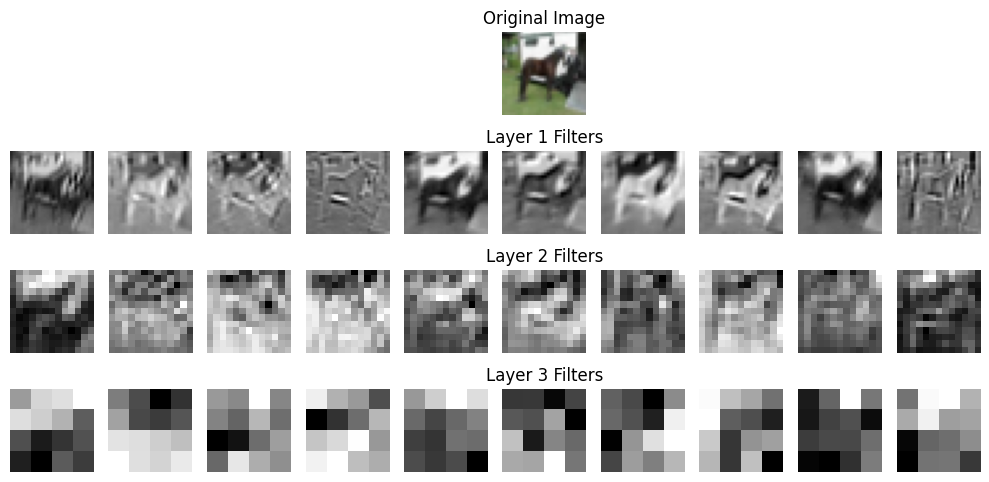

In [ ]:
import matplotlib.pyplot as plt
import torch
import random

# Assume model is a PyTorch model and image is a single image tensor
model.eval()  # Set the model to evaluation mode
num_filters = 10

# Retrieve a single image from the test dataset
images, labels = next(iter(test_loader))
image_idx = random.randint(0, len(images) - 1)
image = images[image_idx].to(device)

# Function to plot a grid of images
def plot_images_grid(images, title, num_rows, num_cols, axes):
    for idx, img in enumerate(images):
        ax_idx = idx + 1
        ax_sub = axes[ax_idx % num_cols]
        ax_sub.imshow(img, cmap='gray')
        ax_sub.axis('off')
    axes[num_cols // 2].set_title(title)

# Normalize the image to display it
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)

unnormalize = T.Normalize(
    mean=[-m/s for m, s in zip(norm_mean, norm_std)],
    std=[1/s for s in norm_std]
)
image_disp = unnormalize(image)
npimg = image_disp.cpu().numpy()
plt_image = np.transpose(npimg, (1, 2, 0))

# Prepare figure
fig, axes = plt.subplots(4, num_filters, figsize=(10, 5))

# Show the raw image
axes[0, num_filters // 2].imshow(plt_image)
axes[0, num_filters // 2].set_title('Original Image')
[ax.axis('off') for ax in axes[0]]

# Get the outputs from the layers
outputs = []
layers = list(model.conv_layers.children())
image = image.unsqueeze(0)
for i, layer in enumerate(layers):
    # TODO: Apply the filters of the convolutional layer to the image and store the output to the outputs list
    image = layer(image)
    if type(layer) == nn.Conv2d:
      outputs.append(image)

# Visualize 10 random filters from each layer output
for i, output in enumerate(outputs):
    layer_filters = output[0]  # Get the filters for the first image in the batch
    # Randomly select 10 filters
    if layer_filters.shape[0] > num_filters:
        selected_filters = random.sample(range(layer_filters.shape[0]), num_filters)
    else:
        selected_filters = range(layer_filters.shape[0])
    filter_images = [layer_filters[idx].cpu().detach().numpy() for idx in selected_filters]
    plot_images_grid(filter_images, f'Layer {i + 1} Filters', 1, num_filters, axes[i + 1])

plt.tight_layout()
plt.show()

### Section 1.2: Hyperparameter Optimization with Ray Tune (15 points)
Hyperparameter search is an essential part in the development of deep learning models. Ray Tune is a framework for hyperparameter optimization. It provides a simple interface for defining search spaces and supports various search algorithms such as grid search, random search, and Bayesian optimization.
This section will explore and optimize hyperparameters for the convolutional neural network on the CIFAR-10 dataset.

#### Exercise 8: Basic Setup and Grid Search (8 points)

This exercise will walk through the basic setup and grid search steps for the convolutional neural network on the CIFAR-10.
We will use Ray Tune to perform a search over the learning rate and weight decay of the network.

Firstly, ensure that Ray Tune is installed in your Jupyter environment.
If not, you can execute the following cell.

In [ ]:
%pip install ray[tune]

Next, we define a training function `train_ray(config)` that incorporates Ray Tune.
This function is largely similar to the `train` function in the previous section, but should (1) use `hyperparameters` from the `config` argument to initialize the optimizer and (2) report training loss using `tune.report()` at the end of each training epoch.

**Note that I haven't divided the loss function by the size of train data because I didn't think there would cause any difference in the optimization but I did divide while plotting.**

In [ ]:
import ray
from ray import tune
from ray import train
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# Define the training function
def train_ray(config):
    # Load datasets
    train_set = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
    train_loader = DataLoader(
        train_set, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(num_train_samples)))

    # Define the network and criterion function
    model = ConvNet().to(device)
    criterion = torch.nn.CrossEntropyLoss()

    # TODO: Initialize the optimizer with the hyperparameters defined in the config
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

    # TODO: Define the training loop. You can copy this function from the previous section
    for _ in range(10):  # Loop over the dataset multiple times
        running_loss = 0.0

        # TODO: Report metrics `loss` at the end of each training epoch
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(train_loader):
          inputs, labels = batch[0].to(device), batch[1].to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
        train.report({"loss": running_loss})

Thereafter, we define an appropriate search space `config` for the two hyperparameters (learning rate and weight decay).
You may refer to the [Tune Search Space API](https://docs.ray.io/en/latest/tune/api/search_space.html) for details.

After that, use `tune.run()` to execute the search with the `ASHAScheduler` that tries to minimize the loss.
Output and discuss the best hyperparameters found.

In [ ]:
# TODO: Define the hyperparameter search space
config = {
    'lr': tune.loguniform(1e-5, 1e-3),
    'weight_decay': tune.loguniform(1e-6, 1e-4),
}


# Initialize Ray Tune
ray.shutdown()
ray.init()
scheduler = ASHAScheduler(metric='loss', mode='min')
reporter = CLIReporter(metric_columns=['loss'])

# Execute the hyperparameter search
analysis = tune.run(
    train_ray,
    resources_per_trial={'gpu': 1},  # If you want to use GPUs, you can set {'gpu': 1} instead
    config=config,
    num_samples=5,
    scheduler=scheduler,
    progress_reporter=reporter
)

# Get the best hyperparameters
best_config = analysis.get_best_config(metric='loss', mode='min')
print('Best hyperparameters found are: ', best_config)

2024-01-31 18:36:38,978	INFO worker.py:1724 -- Started a local Ray instance.
2024-01-31 18:36:40,819	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-01-31 18:36:40,880	WARNING tune.py:916 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+------------------------------------------------------------------+
| Configuration for experiment     train_ray_2024-01-31_18-36-40   |
+------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator           |
| Scheduler                        AsyncHyperBandScheduler         |
| Number of trials                 5                               |
+------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_ray_2024-01-31_18-36-40
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/train_ray_2024-01-31_18-36-40`

Trial status: 5 PENDING
Current time: 2024-01-31 18:36:41. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------+
| Trial name              status              lr     weight_decay |
+---------------------------

#### Exercise 9: Hyperparameter Search with Bayesian Optimization (7 points)
In the next exercise, we are going to implement hyperparameter optimization using an advanced search algorithm --- Bayesian Optimization and compare the results of the advanced method with the basic grid/random search from Exercise 6.
You may refer to the [Bayesian Optimization Search](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.search.bayesopt.BayesOptSearch.html#ray.tune.search.bayesopt.BayesOptSearch) for detailed understanding of the API.

To implement Bayesian Optimization, we can use the same `train_ray(config)` function from previous exercises.
However, for the search space, Bayesian Optimization works best with **continuous parameters** and a smaller search space.
Then, we can execute the hyperparameter tuning using `BayesOptSearch` in Ray Tune.

In [ ]:
!pip install bayesian-optimization

In [ ]:
from ray.tune.search.bayesopt import BayesOptSearch

# TODO: Initialize the BayesOptSearch object
bayesopt = BayesOptSearch(metric='loss', mode='min')

config = {
    'lr': tune.loguniform(1e-5, 1e-3),
    'weight_decay': tune.loguniform(1e-6, 1e-4),
}

analysis = tune.run(
    train_ray,
    resources_per_trial={'gpu': 1},  # If you want to use GPUs, you can set {'gpu': 1} instead
    config=config,
    num_samples=5,
    search_alg=bayesopt,
    scheduler=scheduler,
    progress_reporter=reporter
)

# Get the best hyperparameters
best_config = analysis.get_best_config(metric='loss', mode='min')
print('Best hyperparameters found are: ', best_config)

2024-01-31 19:16:37,025	INFO worker.py:1724 -- Started a local Ray instance.
2024-01-31 19:16:38,271	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-01-31 19:16:38,280	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-01-31 19:16:38,342	WARNING bayesopt_search.py:431 -- BayesOpt does not support specific sampling methods. The LogUniform sampler will be dropped.
2024-01-31 19:16:38,347	WARNING bayesopt_search.py:431 -- BayesOpt does not support specific sampling methods. The LogUniform sampler will be dropped.
2024-01-31 19:16:38,935	WARNING tune.py:916 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+------------------------------------------------------------------+
| Configuration for experiment     train_ray_2024-01-31_19-16-38   |
+------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                 |
| Scheduler                        AsyncHyperBandScheduler         |
| Number of trials                 5                               |
+------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_ray_2024-01-31_19-16-38
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/train_ray_2024-01-31_19-16-38`

Trial status: 1 PENDING
Current time: 2024-01-31 19:16:39. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------+
| Trial name           status              lr     weight_decay |
+---------------------------------

Ray Tune provides built-in functions that track the progress/performance of each trial, which can be retrieved from `analysis.trial_dataframes`.
Visualize the results using `matplotlib` to show the comparison in terms of performance metrics across different hyperparameter settings.
Last, compare the results from Exercise 6 where we implemented grid/random search with those obtained from Bayesian Optimization.

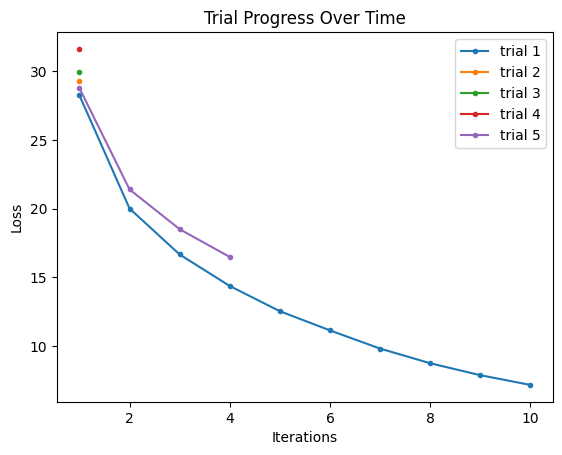

In [ ]:
from matplotlib import pyplot as plt

dfs = analysis.trial_dataframes
idx = 1

for d in dfs.values():
    # TODO: Plot the results
    plt.plot(d["training_iteration"], d["loss"] / len(train_loader), ".-", label="trial " + str(idx))
    idx += 1
    pass

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Trial Progress Over Time')
plt.show()

### Section 1.3: CIFAR-10 Open-End Challenge (20 bonus points)

The last part aims to enhance and optimize your neural network to achieve the highest possible accuracy on the CIFAR-10 dataset. This part focuses on experimenting with advanced features, layers, optimizers, and hyperparameters to improve model performance, such as:
* [Data Augmentation](https://pytorch.org/vision/stable/transforms.html): This involves applying transformations like rotation, scaling, cropping, flipping, etc., to the training images. This can increase the diversity of the training data and help the model generalize better to new, unseen data.
* [Batch](https://arxiv.org/abs/1502.03167)/[Layer Normalization](https://arxiv.org/abs/1607.06450): These techniques normalize the inputs to a layer within a network, helping in stabilizing and speeding up the training. Batch normalization is applied to batches of data, while layer normalization is applied across a single layer.
* [Learning Rate Scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate): Adjusting the learning rate during training (e.g., reducing it gradually) can help in fine-tuning the network's weights more effectively, especially as the training process progresses.
* [Early Stopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/): To prevent overfitting, you can monitor the validation loss and stop the training process when the loss starts to increase, indicating that the model is starting to learn noise from the training data.
* [Residual Connections](https://arxiv.org/abs/1512.03385): Particularly useful in deep networks, residual connections help in mitigating the vanishing gradient problem by allowing an alternative shortcut path for the gradient to flow through.
* [Regularization Techniques](https://www.deeplearningbook.org/contents/regularization.html): Techniques like L2 regularization or dropout can be used to reduce overfitting by adding a penalty to the loss function or randomly dropping out neurons during training.
* [Adaptive Optimization Algorithms](http://pytorch.org/docs/stable/optim.html): Optimizers like [Adam](https://arxiv.org/abs/1412.6980), [RMSprop](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf), etc., adapt their learning rates based on the training process and can lead to faster convergence.

Please briefly describe the architecture of the model and analyze the impact of different techniques on model performance.
You need at least experiment with three advanced techniques and achieve 70% accuracy on the validation set for the **first 10 epochs**.

Tips for training:

* Early Indicators of Success: When tuning parameters, if they are effective, you should observe a noticeable improvement within the first few hundred iterations. This early indication is crucial for validating the direction of your hyperparameter adjustments.
* Coarse-to-Fine Hyperparameter Tuning: Start by testing a broad range of hyperparameters over a few training iterations. This "coarse" search helps identify parameter sets that show any promise at all. Once you identify promising hyperparameter ranges, refine your search. This "fine" tuning involves more nuanced adjustments and possibly longer training epochs.
* Validation Set for Hyperparameter Tuning: Always use the validation set for hyperparameter tuning. This set is critical for evaluating the effectiveness of your hyperparameters without tapping into the test set. Reserve the test set exclusively for the final evaluation of your model. It should only be used to assess performance after you have finalized your model's architecture and hyperparameters based on the validation set.

**I used dropout after the convolutional layers, data augmentation (like random horizontal flip, random rotation, random affine, and color jitter) and Adam optimizer (Which is much better than SGD).**

Dropouts are important for regularization purposes. During dropout we disregard certain nodes in a layer at random during training. This prevents overfitting by ensuring that no units are codependent with one another.

Data Augmentation helps to create more unseen samples for training the network and helps with the robustness of the network.

In [ ]:
import torch
import torchvision
import numpy as np
from torchvision import transforms as T
from torch.utils.data import sampler, DataLoader

import os
from os import path

data_path = path.join(os.getcwd(), 'data')

batch_size = 64
num_train_samples = 48000

# Transformations and CIFAR-10 dataset loading
transform_train = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(), # for augmentation
    T.RandomRotation(10), # for augmentation
    T.RandomAffine(0, shear=10, scale=(0.8,1.2)), # for augmentation
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # for augmentation
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_set = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform_train)
valid_set = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
train_loader = DataLoader(
    train_set, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(num_train_samples)))
valid_loader = DataLoader(
    valid_set, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(num_train_samples, 50000)))

test_set = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # TODO: Implement convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        # TODO: Implement the fully connected layer
        shape = (128, 2, 2)

        self.fc = nn.Sequential(
            nn.Linear(np.prod(shape), 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

        self.dropout = nn.Dropout(0.5)

        # Initialize weights using Kaiming Normal initialization
        self._initialize_weights()

    def forward(self, x):
        # TODO: Implement the forward pass
        x = self.conv_layers(x)
        x = self.dropout(x)
        x = self.fc(x.reshape((x.shape[0], np.prod(x.shape[1:]))))
        return x

    def _initialize_weights(self):
        # TODO: Implement weight initialization using Kaiming Normal initialization
        for conv in self.conv_layers:
          if type(conv) == nn.Conv2d:
            nn.init.kaiming_uniform_(conv.weight)

In [ ]:
print_every = 1

In [ ]:
# TODO: Construct your model
model = ConvNet().to(device)

# TODO: Copy the definition of the loss function and the optimizer from earlier cells
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)

# TODO: Run the training loop again
train(model, train_loader, valid_loader, criterion, optimizer, epochs=20)

# TODO: Evaluate the model on the test set
test_accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/20], Loss: 1.7185, Validation Accuracy: 51.10%
Epoch [2/20], Loss: 1.4343, Validation Accuracy: 56.65%
Epoch [3/20], Loss: 1.3262, Validation Accuracy: 60.60%
Epoch [4/20], Loss: 1.2437, Validation Accuracy: 65.35%
Epoch [5/20], Loss: 1.1834, Validation Accuracy: 65.15%
Epoch [6/20], Loss: 1.1340, Validation Accuracy: 67.65%
Epoch [7/20], Loss: 1.1011, Validation Accuracy: 70.05%
Epoch [8/20], Loss: 1.0734, Validation Accuracy: 69.95%
Epoch [9/20], Loss: 1.0379, Validation Accuracy: 72.05%
Epoch [10/20], Loss: 1.0238, Validation Accuracy: 72.40%
Epoch [11/20], Loss: 1.0002, Validation Accuracy: 73.00%
Epoch [12/20], Loss: 0.9870, Validation Accuracy: 72.45%
Epoch [13/20], Loss: 0.9683, Validation Accuracy: 73.65%
Epoch [14/20], Loss: 0.9503, Validation Accuracy: 74.90%
Epoch [15/20], Loss: 0.9418, Validation Accuracy: 74.95%
Epoch [16/20], Loss: 0.9247, Validation Accuracy: 75.35%
Epoch [17/20], Loss: 0.9138, Validation Accuracy: 75.80%
Epoch [18/20], Loss: 0.9084, Validation 